# initilise the search space


In [1]:

import os
#os.chdir('c:\\Users\\ma11115\\OneDrive - Imperial College London\\github_folder\\STK_SEARCH\\')
os.chdir('/rds/general/user/ma11115/home/STK_Search/STK_search')

from stk_search import Searched_space
import importlib
importlib.reload(Searched_space)
import pickle
import pymongo
import pandas as pd
import numpy as np
from stk_search.utils import database_utils


In [2]:
# load the data and the precursors dataset
importlib.reload(database_utils)
df_total_path = "data/output/Full_dataset/New_target200324.csv"
df_precursors_path ="data/output/Prescursor_data/precursor_data_200324.pkl"
df_properties_path = "data/input/Prescursor_data/df_properties_10052024.pkl"
df_total_new , df_precursors= database_utils.load_data_from_file(df_total_path, df_properties_path)

/rds/general/user/ma11115/home/STK_Search/STK_search/src/stk_search/utils/database_utils.py:109: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_total = pd.read_csv(df_path)


In [3]:
df_precursors.head()

,electron affinity (eV),homo lumo_gap (eV),ionisation potential (eV),total energy (au),ES1,fosc1,InChIKey,mol_opt
0,1.5987,0.309035,7.5397,-49.456016,3.187,0.0093,AEXMFBWMBBWABJ-AOOOYVTPSA-N,<rdkit.Chem.rdchem.Mol object at 0x150de18ce390>
1,0.9251,0.873029,7.3488,-50.996814,3.853,0.2833,AKCYMAPLDZOXLO-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x150de18ce480>
2,0.4792,0.339301,8.1112,-36.060745,4.926,0.0030,AMGZARGPNNDZNG-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x150de18ce520>
3,2.8229,0.263578,8.6481,-61.921427,3.495,0.0920,AQOFMDQMNLWXDY-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x150de18ce660>
4,0.1140,0.078029,7.8125,-55.053911,4.864,0.0005,AUHBXOFOJLXABB-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x150ddec0b2e0>


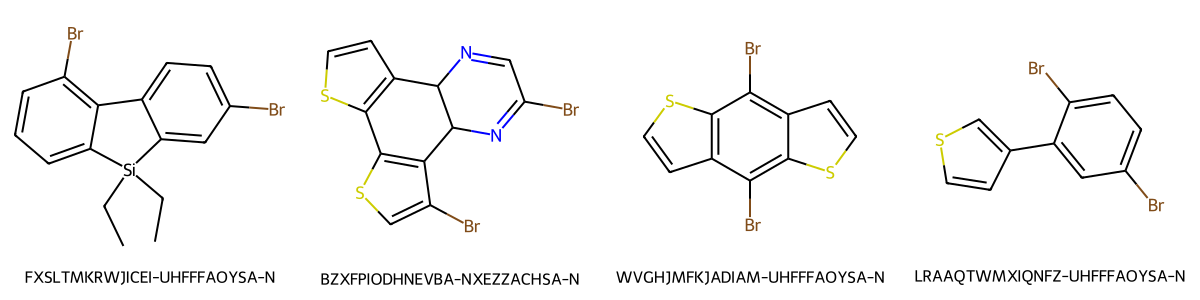

In [4]:
# plot some example of precursors
from rdkit.Chem import Draw
from rdkit import Chem
mol_list = []
mol_label = []
df_to_plot = df_precursors.sample(4)
df_to_plot['mol_opt_smiles'] = df_to_plot['mol_opt'].apply(lambda x : Chem.MolFromSmiles(Chem.MolToSmiles(x)))
mol_list.extend(df_to_plot['mol_opt_smiles'].values)
mol_label.extend(df_to_plot['InChIKey'].values)
# Draw molecules
img = Draw.MolsToGridImage(mol_list, molsPerRow=4, subImgSize=(300, 300),legends=[f"{label}" for label in mol_label])  # adjust molsPerRow and subImgSize as needed
img

In [5]:
#%%  generate the search space

number_of_fragments = 6
target_name = 'target' # specify the target name ( here target refers to the combined property)
aim = 0.0 # specify the target value

SP = Searched_space.Searched_Space(number_of_fragments=number_of_fragments,df=df_precursors,features_frag=df_precursors.columns[0:1],generation_type='conditional')
print(SP.features_frag)
SP.generate_interactive_condition_V2(df_total=df_total_new)

Index(['electron affinity (eV)'], dtype='object')


In [ ]:
import glob
#%% 

search_spaces_dfs = glob.glob('data/*pkl')
for id,df_path_SP in enumerate(search_spaces_dfs):
    print(id,df_path_SP)


In [ ]:
df_SP = pd.read_pickle(search_spaces_dfs[0])
df_SP.reset_index(drop=True,inplace=True)
df_SP

In [ ]:
# load the saved dataframe with all the tested conditions
# and output it in order to select a few to add to the bactk experiment

import pickle
from datetime import datetime
import os

def save_SP_for_EXP(df:pd.DataFrame,index_list:list,exp_name:str,number_of_fragments):
    time_now = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    save_dir = f'data/input/EXP_search_space/{exp_name}_{time_now}/'
    os.makedirs(save_dir,exist_ok=True)
    SP = Searched_space.Searched_Space(number_of_fragments=number_of_fragments,df=df_precursors,features_frag=df_precursors.columns[0:1],generation_type='conditional')
    SP.features_frag=SP.features_frag.append(df_precursors.columns[17:23])
    SP.features_frag=SP.features_frag.append(df_precursors.columns[1:7])

    for id in index_list:
        SP.conditions_list = df['conditions'].values[id]
        SP.syntax = list(df['syntax'].values[id])[:number_of_fragments]
        SP.redefine_search_space()
        print(f"{SP.space_size:.2e}")
        print(SP.syntax)
        print(SP.conditions_list)
        pickle.dump(SP,file=open(save_dir+f'/search_space_{id}.pkl','wb'))
    return SP, save_dir
experiment_name = '6_frag_all'
SP,save_dir= save_SP_for_EXP(df_SP,[0,4],experiment_name,number_of_fragments)

In [ ]:
306*306